# VAE with CelebA dataset

In [1]:
import torch
import os
import torch.nn as nn

import torchvision
from torchvision import datasets

from models import VariationalAutoEncoderCelebA
from tqdm.auto import tqdm, trange
import numpy as np

import pandas as pd

from PIL import Image

from utils import output_to_pil

from scipy.stats import norm

import joblib

from scipy import spatial

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

print(torch.__version__)

1.7.0


In [2]:
def load_image(path):
    img = Image.open(path)
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor()
    ])
    return transform(img)


class Dataset:
    def __init__(self, path_to_jpg):
        self.path = path_to_jpg
        self.filenames = os.listdir(path_to_jpg)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        return load_image(self.path + '/' + self.filenames[item])

In [3]:
data = Dataset("../data/celeba/img_align_celeba/img_align_celeba")
train, valid = torch.utils.data.random_split(data, [int(0.8*len(data)), len(data)-int(0.8*len(data))])

In [4]:
model = VariationalAutoEncoderCelebA(3, 200, 3).to("cuda")
reconstruction_loss_fn = nn.MSELoss().to("cuda")
kl_loss_fn = lambda mu, log_var: -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=False)
kl_factor = 3e-5

In [5]:
REFIT = False

if REFIT:
    for epoch in range(10):

        train_loss = 0
        valid_loss = 0

        model.train()
        for images in tqdm(dataloader, leave=False):
            optimizer.zero_grad()
            mu, log_var, output = model(images.to("cuda"))
            reconstruction_loss = reconstruction_loss_fn(output, images.to("cuda"))
            kl_loss = kl_loss_fn(mu, log_var) / images.size()[0]
            loss = reconstruction_loss + kl_factor * kl_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item() / len(dataloader)

        model.eval()
        with torch.no_grad():
            for images in tqdm(valid_loader, leave=False):
                mu, log_var, output = model(images.to("cuda"))
                reconstruction_loss = reconstruction_loss_fn(output, images.to("cuda"))
                kl_loss = kl_loss_fn(mu, log_var) / images.size()[0]
                loss = reconstruction_loss + kl_factor * kl_loss
                valid_loss += loss.item() / len(valid_loader)

        print(f"Epoch {epoch+1}: train_loss {train_loss}, valid_loss {valid_loss}")
    torch.save(model.state_dict(), "cache/vae_celeba.pt")
else:
    model.load_state_dict(torch.load("cache/vae_celeba.pt"))

Show 10 images before and after model

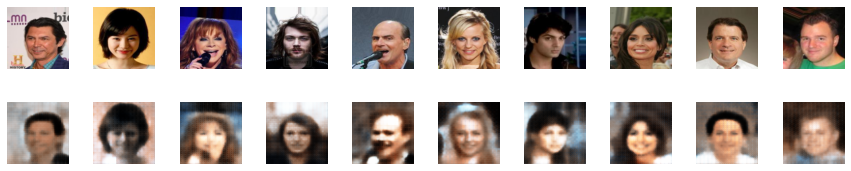

In [6]:
n_to_show = 10

data_iterator = iter(valid_loader)
example_images = [next(data_iterator) for _ in range(10)]
reconst_images = [model(image.cuda())[2].cpu().detach() for image in example_images]

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.imshow(img.permute(1,2,0))

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img.permute(1,2,0))

Check distributions of each dimension

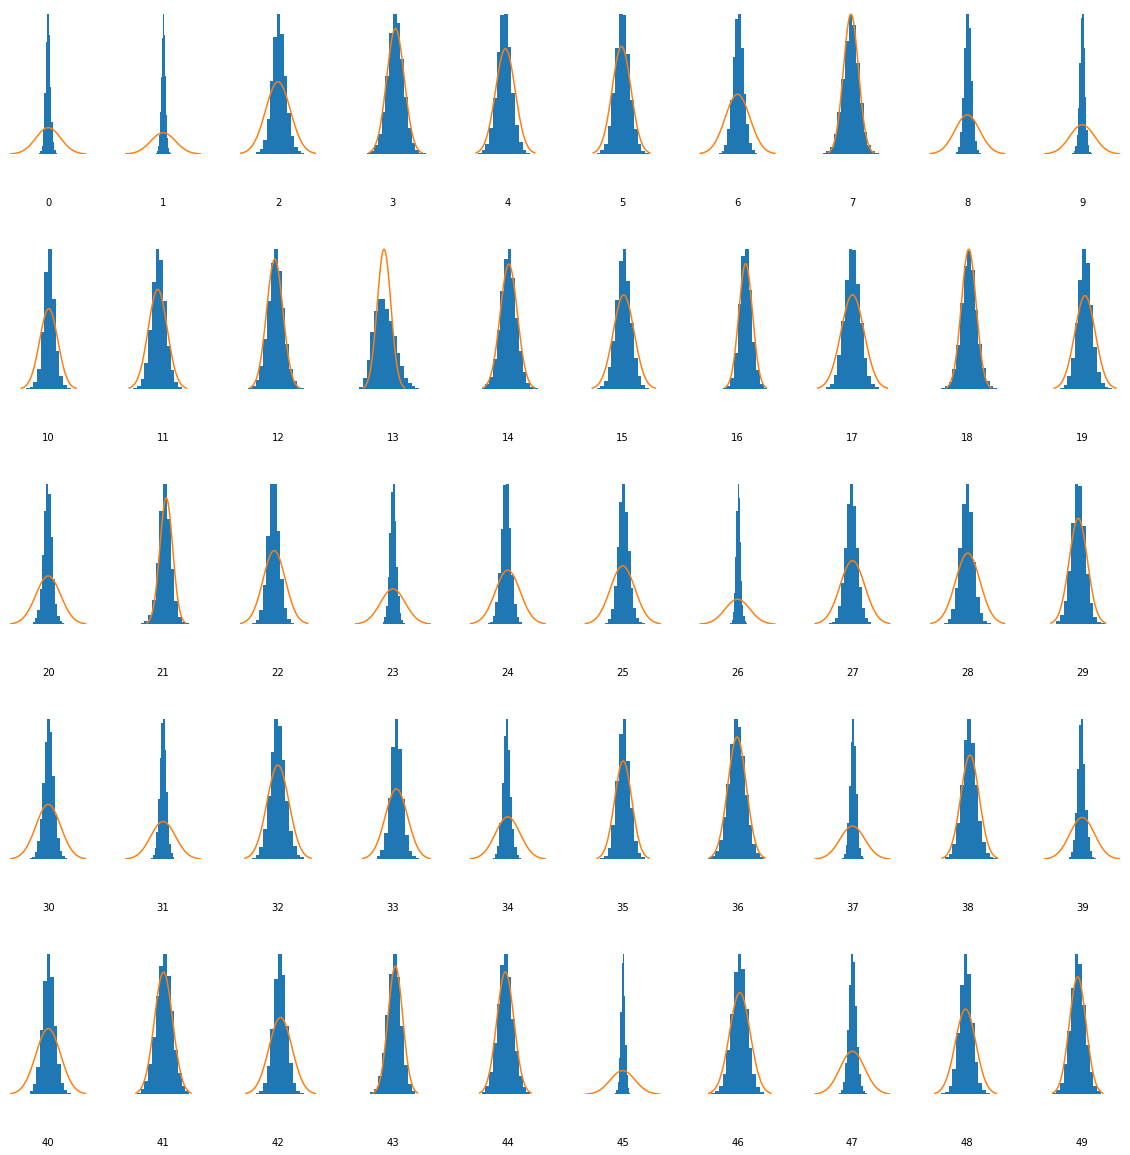

In [7]:
model.eval()
mus = []

with torch.no_grad():
    for images in tqdm(valid_loader, leave=False):
        mu, _, _ = model(images.to("cuda"))
        mus.append(mu.cpu().squeeze().detach().numpy())

mus = np.stack(mus)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(mus[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

Show 30 randomly generated images

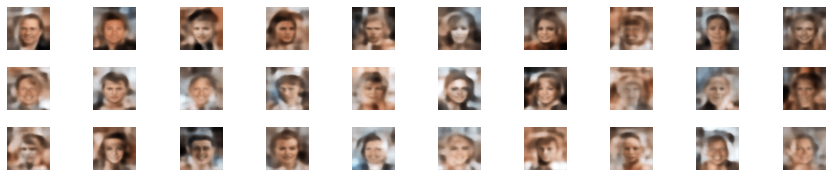

In [8]:
n_to_show = 30

generated_images = [model.decoder(torch.randn(1, 200).cuda()).cpu().detach() for _ in range(n_to_show)]

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in trange(n_to_show):
    img = generated_images[i].squeeze()
    sub = fig.add_subplot(3, 10, i+1)
    sub.axis('off')
    sub.imshow(img.permute(1,2,0))

Find vectors in 200d corresponding to attributes of pictures

In [9]:
if REFIT:
    attr = pd.read_csv("../data/celeba/list_attr_celeba.csv")
    mus = np.empty((len(attr), 200))

    with torch.no_grad():
        for i, filename in tqdm(attr['image_id'].iteritems()):
            image = load_image("../data/celeba/img_align_celeba/img_align_celeba/" + filename).cuda().unsqueeze(0)
            mu, _ = model.encoder(image)
            mus[i] = mu.cpu().detach().squeeze().numpy()

    attr_vector = {}
    for name_attr in attr.drop(columns="image_id").columns:
        attr_vector[name_attr] = np.expand_dims(attr[name_attr].values, 0) @ mus
    joblib.dump(attr_vector, "cache/attr_vector.dump")
else:
    attr_vector = joblib.load("cache/attr_vector.dump")


Examine correlation between attributes

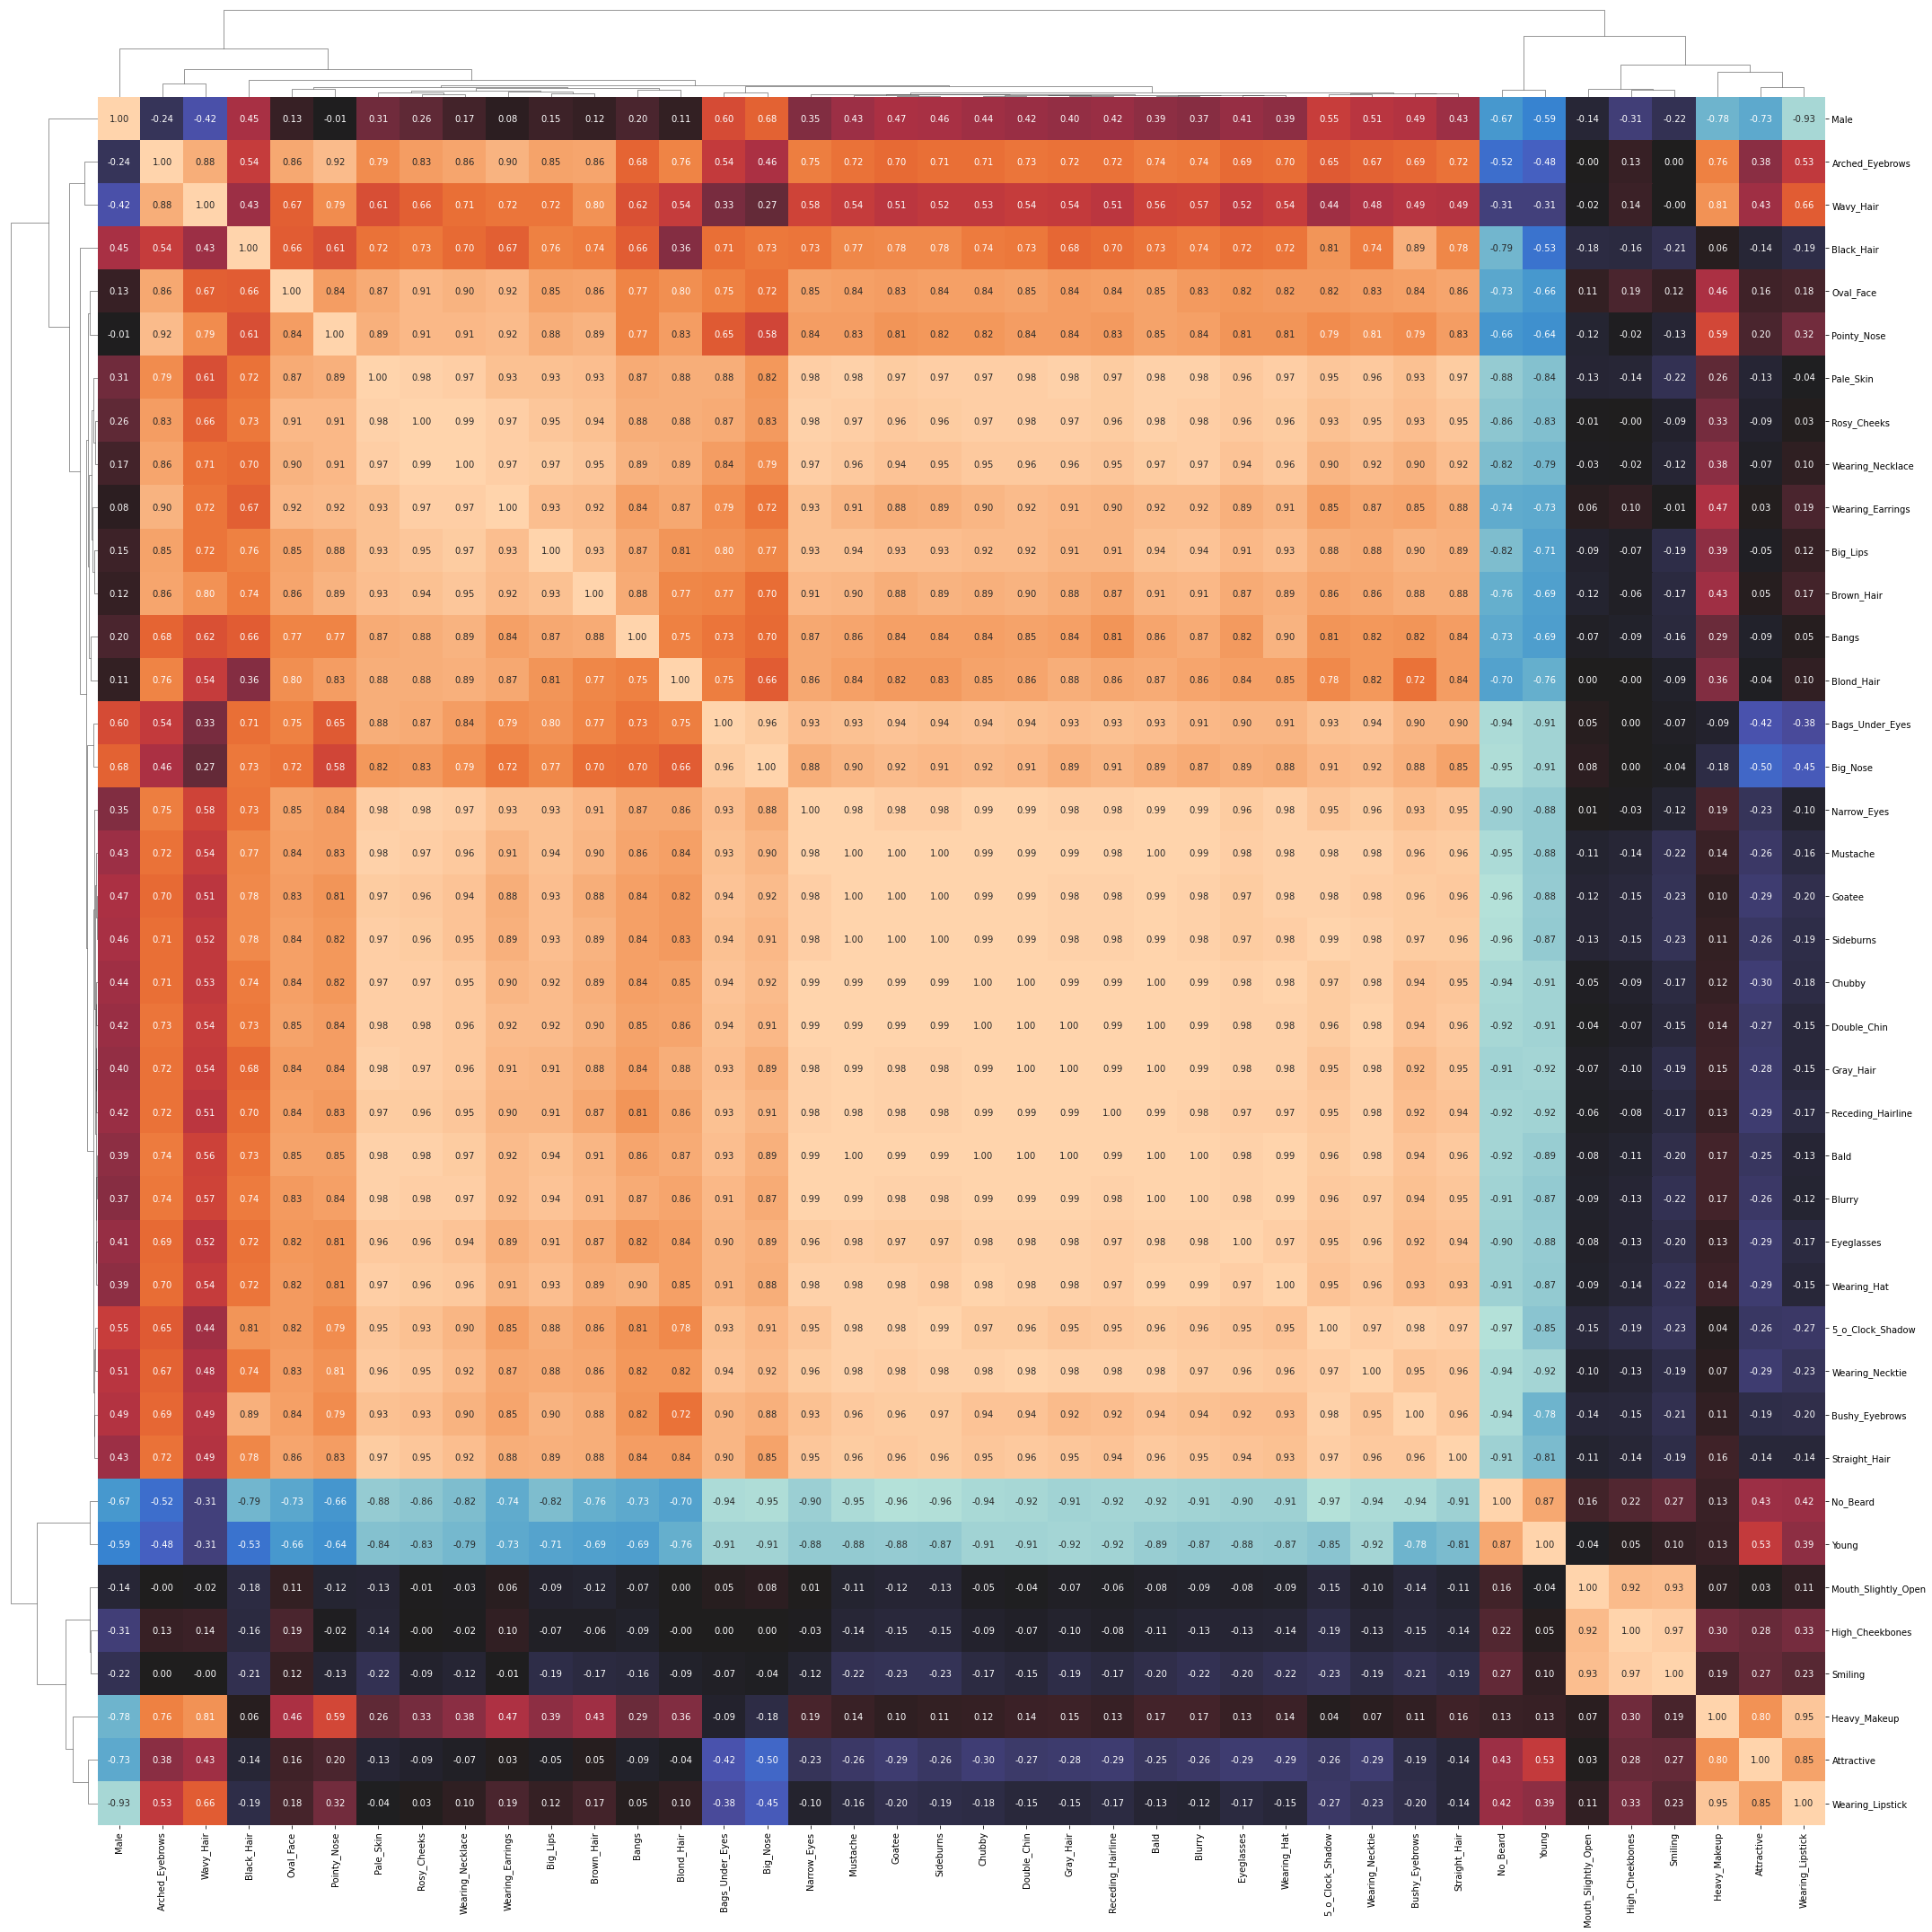

In [11]:
cosines = np.empty((len(attr_vector), len(attr_vector)))
for i, a in enumerate(attr_vector):
    for j, b in enumerate(attr_vector):
        cosines[i][j] = 1 - spatial.distance.cosine(attr_vector[a], attr_vector[b])
sns.clustermap(cosines, center=0, annot=True, fmt=".2f",
               dendrogram_ratio=0.05, figsize=(30,30), cbar_pos=None,
               xticklabels=list(attr_vector.keys()), yticklabels=list(attr_vector.keys()))
plt.show()

Use vectors to change persons

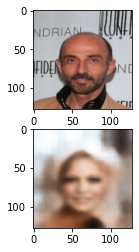

In [59]:
image = next(data_iterator)

model.eval()
with torch.no_grad():
    mu, log_var = model.encoder(image.cuda())
    x = model.reparametrize(mu-(3e-5)*torch.FloatTensor(attr_vector['Male']).cuda(), torch.FloatTensor(np.zeros(200)).cuda())
    output = model.decoder(x).cpu().detach().squeeze()

image = image.cpu().detach().squeeze()

plt.subplot(211)
plt.imshow(image.permute(1,2,0))
plt.subplot(212)
plt.imshow(output.permute(1,2,0))
plt.show()